In [1]:
import collections
import math
import os
import shutil
import pandas as pd
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

In [2]:
d2l.DATA_HUB['cifar10_tiny'] = (d2l.DATA_URL + 'kaggle_cifar10_tiny.zip',
                                '2068874e4b9a9f0fb07ebe0ad2b29754449ccacd')

# 如果使用完整的Kaggle竞赛的数据集，设置demo为False
demo = False

if demo:
    data_dir = d2l.download_extract('cifar10_tiny')
else:
    data_dir = '../data/cifar-10/'

In [3]:
#读取和整理数据集
def read_csv_labels(fname):#参数 fname，表示 CSV 文件的路径
    with open(fname,'r') as f:
        lines=f.readlines()[1:]#跳过文件第一行（列名）
    tokens=[l.rstrip().split(',') for l in lines]
    #CSV全称为‌逗号分隔值‌（Comma-Separated Values）是一种以逗号分隔字段的纯文本文件格式，用于存储表格数据
    #l.rstrip()：移除行尾的换行符
    #split('.')：将每一行按 . 分割成两个部分，通常第一部分是文件名，第二部分是标签
    
    # 将每一行的文件名和标签组合成键值对。
    #使用 dict() 将这些键值对转换为字典。
    return dict(((name,label) for name,label in tokens))

labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
print('# 训练样本 :', len(labels))
print('# 类别 :', len(set(labels.values())))
labels

# 训练样本 : 50000
# 类别 : 10


{'1': 'frog',
 '2': 'truck',
 '3': 'truck',
 '4': 'deer',
 '5': 'automobile',
 '6': 'automobile',
 '7': 'bird',
 '8': 'horse',
 '9': 'ship',
 '10': 'cat',
 '11': 'deer',
 '12': 'horse',
 '13': 'horse',
 '14': 'bird',
 '15': 'truck',
 '16': 'truck',
 '17': 'truck',
 '18': 'cat',
 '19': 'bird',
 '20': 'frog',
 '21': 'deer',
 '22': 'cat',
 '23': 'frog',
 '24': 'frog',
 '25': 'bird',
 '26': 'frog',
 '27': 'cat',
 '28': 'dog',
 '29': 'deer',
 '30': 'airplane',
 '31': 'airplane',
 '32': 'truck',
 '33': 'automobile',
 '34': 'cat',
 '35': 'deer',
 '36': 'airplane',
 '37': 'cat',
 '38': 'horse',
 '39': 'cat',
 '40': 'cat',
 '41': 'dog',
 '42': 'bird',
 '43': 'bird',
 '44': 'horse',
 '45': 'automobile',
 '46': 'automobile',
 '47': 'automobile',
 '48': 'bird',
 '49': 'bird',
 '50': 'airplane',
 '51': 'truck',
 '52': 'dog',
 '53': 'horse',
 '54': 'truck',
 '55': 'bird',
 '56': 'bird',
 '57': 'dog',
 '58': 'bird',
 '59': 'deer',
 '60': 'cat',
 '61': 'automobile',
 '62': 'automobile',
 '63': 'ship',

In [4]:
def copyfile(filename,target_dir):
    os.makedirs(target_dir,exist_ok=True)
    #创建一个名为target_dir的值的目录，若目录已存在，不抛出异常
    shutil.copy(filename,target_dir)

#用于从原始的训练集中拆分出验证集
#labels：一个字典，键是文件名（不包含扩展名），值是对应的标签
#valid_ratio：验证集占训练集的比例
def reorg_train_valid(data_dir,labels,valid_ratio):
    #collections.Counter(labels.values())：统计每个标签出现的次数，返回一个计数器对象
    #.most_common()返回一个列表，按出现次数从高到低排序。
    #n:训练数据集中样本最少的类别中的样本数
    n=collections.Counter(labels.values()).most_common()[-1][1]
    
    #math.floor(x)返回小于参数x的最大整数,即对浮点数向下取整
    #max(1, ...)：确保每个类别至少有一个样本分配给验证集
    #n_valid_per_label就是每个类别分配给验证机的数量
    n_valid_per_label=max(1,math.floor(n*valid_ratio))

    #label_count是一个字典，用于记录每个标签已经分配到验证集的样本数。
    label_count={}
 
    #遍历训练集中的所有文件
    #os.listdir(os.path.join(data_dir, 'train'))：列出训练集目录中的所有文件名。
    for train_file in os.listdir(os.path.join(data_dir,'train')):
        #train_file.split('.')[0]：从文件名中提取不包含扩展名的部分
        #labels[...]从 labels 字典中获取该文件的标签
        label=labels[train_file.split('.')[0]]
        fname=os.path.join(data_dir,'train',train_file)
        copyfile(fname,os.path.join(data_dir,'train_valid_test','train_valid',label))

        #检查是否将文件复制到指定目录了
        #（1）
        #如果该标签尚未出现在label_count中或者该标签的验证集样本数没达到指定数量，就把当前遍历的文件移到验证集目录下面，并更新label_count字典
        if label not in label_count or label_count[label] < n_valid_per_label:
            copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                         'valid', label))
            label_count[label] = label_count.get(label, 0) + 1
        else:
            #（2）否则将文件放到训练集目录下面
            copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                         'train', label))
    return n_valid_per_label



In [5]:
#unknown 目录是一个占位符，表示测试文件的标签在预测时是未知的
def reorg_test(data_dir):
    for test_file in os.listdir(os.path.join(data_dir,'test')):
        copyfile(os.path.join(data_dir,'test',test_file),os.path.join(data_dir,'train_valid_test','test','unknow'))

In [6]:
def reorg_cifar10_data(data_dir, valid_ratio):
    labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
    reorg_train_valid(data_dir, labels, valid_ratio)
    reorg_test(data_dir)

In [7]:
batch_size=32 if demo else 128
valid_ratio=0.1 #将10％的训练样本作为调整超参数的验证集
reorg_cifar10_data(data_dir,valid_ratio)

In [8]:
#使用图像增广解决过拟合
transform_train=torchvision.transforms.Compose([
    torchvision.transforms.Resize(40),
    torchvision.transforms.RandomResizedCrop(32,scale=(0.64,1.0),ratio=(1.0,1.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914,0.4822,0.4465],[0.2023,0.1994,0.2010])
])

transform_test=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914,0.4822,0.4465],[0.2023,0.1994,0.2010])
])

In [9]:
#读取数据集
train_ds, train_valid_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_train) for folder in ['train', 'train_valid']]

valid_ds, test_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_test) for folder in ['valid', 'test']]

In [10]:
import torch.utils
import torch.utils.data
import torch.utils.data.dataloader

#drop_last=True：如果最后一个批次的样本数量不足 batch_size，则丢弃该批次
train_iter,train_valid_iter=[torch.utils.data.DataLoader(
    dataset,batch_size,shuffle=True,drop_last=True) for dataset in (train_ds,train_valid_ds)
    ]
valid_iter=torch.utils.data.DataLoader(valid_ds,batch_size,shuffle=False,drop_last=True)
test_iter=torch.utils.data.DataLoader(test_ds,batch_size,shuffle=False,drop_last=False)

In [11]:
#定义模型
def get_net():
    num_classes=10 #定义分类任务的类别数
    net=d2l.resnet18(num_classes,3)
    return net

loss=nn.CrossEntropyLoss(reduction="none")
#reduction="none" 表示不对损失值进行平均或求和，而是返回每个样本的损失值

In [12]:
#定义训练函数
def train(net,train_iter,valid_iter,num_epochs,lr,wd,devices,lr_period,lr_decay):
    trainer = torch.optim.SGD(net.parameters(), lr=lr, 
                              momentum=0.9,
                              weight_decay=wd)
    scheduler=torch.optim.lr_scheduler.StepLR(trainer,lr_period,lr_decay)
    num_batches,timer=len(train_iter),d2l.Timer()
    legend=['train loss','train acc']
    if valid_iter is not None:
        legend.append('valid acc')
    animator=d2l.Animator(xlabel='epoch',xlim=[1,num_epochs],legend=legend)
    net=nn.DataParallel(net,device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        net.train()
        metric=d2l.Accumulator(3)#训练损失 训练准确率 样本数量
        for i,(features,labels) in enumerate(train_iter):
            timer.start()
            l,acc=d2l.train_batch_ch13(net,features,labels,loss,trainer,devices)
            metric.add(l,acc,labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[2],
                              None))
        if valid_iter is not None:
            valid_acc=d2l.evaluate_accuracy_gpu(net,valid_iter)
            animator.add(epoch+1,(None,None,valid_acc))
        scheduler.step()
        
    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')

train loss 0.133, train acc 0.955, valid acc 0.839
168.2 examples/sec on [device(type='cuda', index=0)]


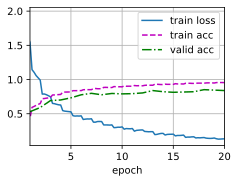

In [13]:
#训练和验证模型
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 20, 2e-4, 5e-4
#当lr_period和lr_decay分别设置为4和0.9时，优化算法的学习速率将在每4个周期乘以0.9
lr_period, lr_decay, net = 4, 0.9, get_net()
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

train loss 0.135, train acc 0.952
171.0 examples/sec on [device(type='cuda', index=0)]


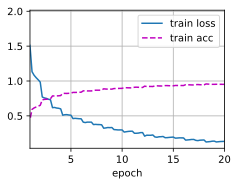

In [14]:
net, preds = get_net(), []
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

for X, _ in test_iter:
    y_hat = net(X.to(devices[0]))
    preds.extend(y_hat.argmax(dim=1).type(torch.int32).cpu().numpy())
#y_hat：模型的输出，形状为 (batch_size, num_classes)，表示每个样本的类别预测概率
#y_hat.argmax(dim=1)：在每个样本的类别预测概率中，找到概率最大的类别索引。返回的张量形状为 (batch_size,)
#.type(torch.int32)：将返回的索引张量转换为 torch.int32 类型
#.cpu().numpy()：将张量移动到 CPU 上，并转换为 NumPy 数组

sorted_ids = list(range(1, len(test_ds) + 1))
#len(test_ds) 是测试集的样本数量
#生成一个整数列表，用于标识训练集的每个样本

sorted_ids.sort(key=lambda x: str(x))
df = pd.DataFrame({'id': sorted_ids, 'label': preds})
df['label'] = df['label'].apply(lambda x: train_valid_ds.classes[x])
df.to_csv('submission.csv', index=False)